#### HW3

#### Question 1

Using CRSP stock data, define the universe of monthly returns that can be used in calculating
momentum portfolios, as well as their ranking return, following the procedure in Daniel and
Moskowitz (2016) 1. Your output should be from 1927-2023

Load data

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import datetime
import time
import matplotlib.pyplot as plt
import wrds
from pandas.tseries.offsets import *
import pandas_datareader
from scipy.stats import skew

In [8]:
conn = wrds.Connection(wrds_username = "frankgong")
crsp_raw = conn.raw_sql("""
                        select a.permno, a.permco, a.date, b.shrcd, b.exchcd, 
                      a.ret, a.retx, a.shrout, a.prc, a.cfacshr, a.cfacpr
                      from crspq.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1926' and '12/31/2024'
                        """)
crsp_raw = crsp_raw.sort_values(['permno','date']).reset_index(drop = True).copy()
crsp_raw[['permno','permco']] = crsp_raw[['permno','permco']].astype(int)
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'],format = "%Y-%m-%d",errors = 'ignore')+MonthEnd(0)



Loading library list...
Done


C:\Users\14561\AppData\Local\Temp\ipykernel_26116\805863334.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  crsp_raw['date'] = pd.to_datetime(crsp_raw['date'],format = "%Y-%m-%d",errors = 'ignore')+MonthEnd(0)


In [9]:
dlret_raw = conn.raw_sql("""
                         select permno, dlret, dlstdt, dlstcd
                         from crspq.msedelist
                         """)
dlret_raw = dlret_raw.sort_values(['permno','dlstdt']).reset_index(drop=True).copy()
dlret_raw.permno = dlret_raw.permno.astype(int)
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'])
dlret_raw['date'] = dlret_raw['dlstdt']+MonthEnd(0)

In [10]:
# merge dlret into ret
crsp = crsp_raw.merge(dlret_raw[['permno','dlret','date']], on=['permno','date'],how = 'outer')
crsp  = crsp[['permno','date','shrcd','exchcd','ret','dlret','prc','shrout']]

In [11]:
crsp = crsp[(crsp['exchcd'].isin([1,2,3]) & crsp['shrcd'].isin([10,11]))]

# merge dlret and fix ret
# if ret and dlret both exist
crsp['ret'] = np.where(crsp['ret'].notna() & crsp['dlret'].notna(),(1+crsp['ret'])*(1+crsp['dlret'])-1, crsp['ret'])
# if only one value exist
crsp['ret'] = np.where(crsp['ret'].isna()  & crsp['dlret'].notna(), crsp['dlret'], crsp['ret'])
# if both na
crsp['ret'] = np.where(crsp['ret'].isna() & crsp['dlret'].isna(),0,crsp['ret'])
crsp

,permno,date,shrcd,exchcd,ret,dlret,prc,shrout
1,10000,1986-01-31,10.0,3.0,0.000000,NaN,-4.37500,3680.0
2,10000,1986-02-28,10.0,3.0,-0.257143,NaN,-3.25000,3680.0
3,10000,1986-03-31,10.0,3.0,0.365385,NaN,-4.43750,3680.0
4,10000,1986-04-30,10.0,3.0,-0.098592,NaN,-4.00000,3793.0
5,10000,1986-05-31,10.0,3.0,-0.222656,NaN,-3.10938,3793.0
...,...,...,...,...,...,...,...,...
5036828,93436,2023-08-31,11.0,3.0,-0.034962,NaN,258.07999,3173994.0
5036829,93436,2023-09-30,11.0,3.0,-0.030456,NaN,250.22000,3179000.0
5036830,93436,2023-10-31,11.0,3.0,-0.197346,NaN,200.84000,3178921.0
5036831,93436,2023-11-30,11.0,3.0,0.195379,NaN,240.08000,3178921.0


In [12]:
CRSP_Data = crsp.copy()

In [13]:
crsp.head(10)

,permno,date,shrcd,exchcd,ret,dlret,prc,shrout
1,10000,1986-01-31,10.0,3.0,0.000000,NaN,-4.37500,3680.0
2,10000,1986-02-28,10.0,3.0,-0.257143,NaN,-3.25000,3680.0
3,10000,1986-03-31,10.0,3.0,0.365385,NaN,-4.43750,3680.0
4,10000,1986-04-30,10.0,3.0,-0.098592,NaN,-4.00000,3793.0
5,10000,1986-05-31,10.0,3.0,-0.222656,NaN,-3.10938,3793.0
6,10000,1986-06-30,10.0,3.0,-0.005025,NaN,-3.09375,3793.0
7,10000,1986-07-31,10.0,3.0,-0.080808,NaN,-2.84375,3793.0
8,10000,1986-08-31,10.0,3.0,-0.615385,NaN,-1.09375,3793.0
9,10000,1986-09-30,10.0,3.0,-0.057143,NaN,-1.03125,3793.0
10,10000,1986-10-31,10.0,3.0,-0.242424,NaN,-0.78125,3843.0


In [14]:
CRSP_Data = crsp.copy()
def PS3_Q1(CRSP_Data):
    
    CRSP_Data['Year'] = CRSP_Data['date'].dt.year
    CRSP_Data['Month'] = CRSP_Data['date'].dt.month
    
    CRSP_Data["Mkt_Cap"] = np.abs(CRSP_Data['prc']*CRSP_Data['shrout'])
    CRSP_Data['Lag_Mkt_Cap'] = CRSP_Data[['permno','Mkt_Cap']].groupby('permno').shift(1)
    
    CRSP_Data['log_ret'] = np.log(1+CRSP_Data['ret'])
    

    # calculare ranking return
    lag_label_list =[]
    for i in range(2,13):
        label = f'log_ret_lag{i}'
        CRSP_Data[label] = CRSP_Data.groupby('permno')['log_ret'].shift(i)
        lag_label_list.append(label)
    
    CRSP_Data['cum_log_ret_lag'] = CRSP_Data.loc[:,lag_label_list].sum(axis = 1)
    #CRSP_Data['cum_ret_lag'] = np.exp(CRSP_Data['cum_log_ret_lag'])-1
        
    # drop records that does not meet the creteria
    # price at t-10 not missing
    # so that we have asset data since 1927-1
    CRSP_Data['prc_lag_10'] = CRSP_Data.groupby('permno')['prc'].shift(10)
    CRSP_Data = CRSP_Data.dropna(subset=['prc_lag_10'])
    # ret(t-2) not missing
    CRSP_Data['ret_lag_2'] = CRSP_Data.groupby('permno')['ret'].shift(2)
    CRSP_Data = CRSP_Data.dropna(subset=['ret_lag_2'])
    # me(t-1) not missing
    CRSP_Data = CRSP_Data.dropna(subset=['Lag_Mkt_Cap'])  


    # CRSP_Data['Ranking_Ret'] = CRSP_Data.groupby('date')['cum_ret'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
    
    return_df = CRSP_Data[['Year','Month','permno','exchcd','Lag_Mkt_Cap','ret','cum_log_ret_lag']]
    return_df.columns = ['Year','Month','PERMNO','EXCHCD','Lag_Mkt_Cap','Ret','Ranking_Ret']
    
    return return_df

CRSP_Stocks_Momentum = PS3_Q1(CRSP_Data) 
CRSP_Stocks_Momentum 
    
    
    

d:\Applications\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\14561\AppData\Local\Temp\ipykernel_26116\3827303525.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRSP_Data['ret_lag_2'] = CRSP_Data.groupby('permno')['ret'].shift(2)


,Year,Month,PERMNO,EXCHCD,Lag_Mkt_Cap,Ret,Ranking_Ret
13,1987,1,10000,3.0,1.981566e+03,-0.212121,-1.664498
14,1987,2,10000,3.0,1.581531e+03,0.000000,-2.138282
15,1987,3,10000,3.0,1.581531e+03,-0.384615,-2.079441
16,1987,4,10000,3.0,9.732500e+02,-0.062500,-2.390877
17,1987,5,10000,3.0,9.124413e+02,-0.066667,-2.772587
...,...,...,...,...,...,...,...
5036828,2023,8,93436,3.0,8.488212e+08,-0.034962,-0.126770
5036829,2023,9,93436,3.0,8.191443e+08,-0.030456,-0.030128
5036830,2023,10,93436,3.0,7.954494e+08,-0.197346,-0.027402
5036831,2023,11,93436,3.0,6.384545e+08,0.195379,0.095016


#### Question 2

In [15]:
CRSP_Stocks_Momentum_Q2 = CRSP_Stocks_Momentum.copy()

def PS3_Q2(CRSP_Stocks_Momentum):
    # KRF decil - use breakpoints from NYSE
    # CRSP_Stocks_Momentum = CRSP_Stocks_Momentum[CRSP_Stocks_Momentum['EXCHCD'] == 1]
    # breakpoints = pd.qcut(nyse_df['Ranking_Ret'], 10, labels=False, retbins=True)[1]
    
    # CRSP_Stocks_Momentum['KRF_decile'] = pd.cut(CRSP_Stocks_Momentum['Ranking_Ret'], bins=breakpoints, labels=range(1, 11), include_lowest=True)
    CRSP_Stocks_Momentum_NYSE = CRSP_Stocks_Momentum[CRSP_Stocks_Momentum['EXCHCD'] == 1]
    CRSP_Stocks_Momentum_NYSE['KRF_decile'] = CRSP_Stocks_Momentum_NYSE.groupby(['Year','Month'])['Ranking_Ret'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
    
        # DM decil all firms
    CRSP_Stocks_Momentum['DM_decile'] = CRSP_Stocks_Momentum.groupby(['Year','Month'])['Ranking_Ret'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
    
    return CRSP_Stocks_Momentum,CRSP_Stocks_Momentum_NYSE

CRSP_Stocks_Momentum_decile, CRSP_Stocks_Momentum_decile_NYSE= PS3_Q2(CRSP_Stocks_Momentum_Q2)
CRSP_Stocks_Momentum_decile

C:\Users\14561\AppData\Local\Temp\ipykernel_26116\1142587642.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRSP_Stocks_Momentum_NYSE['KRF_decile'] = CRSP_Stocks_Momentum_NYSE.groupby(['Year','Month'])['Ranking_Ret'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)


,Year,Month,PERMNO,EXCHCD,Lag_Mkt_Cap,Ret,Ranking_Ret,DM_decile
13,1987,1,10000,3.0,1.981566e+03,-0.212121,-1.664498,1
14,1987,2,10000,3.0,1.581531e+03,0.000000,-2.138282,1
15,1987,3,10000,3.0,1.581531e+03,-0.384615,-2.079441,1
16,1987,4,10000,3.0,9.732500e+02,-0.062500,-2.390877,1
17,1987,5,10000,3.0,9.124413e+02,-0.066667,-2.772587,1
...,...,...,...,...,...,...,...,...
5036828,2023,8,93436,3.0,8.488212e+08,-0.034962,-0.126770,5
5036829,2023,9,93436,3.0,8.191443e+08,-0.030456,-0.030128,5
5036830,2023,10,93436,3.0,7.954494e+08,-0.197346,-0.027402,5
5036831,2023,11,93436,3.0,6.384545e+08,0.195379,0.095016,8


In [16]:
CRSP_Stocks_Momentum_decile_NYSE

,Year,Month,PERMNO,EXCHCD,Lag_Mkt_Cap,Ret,Ranking_Ret,KRF_decile
928,1927,1,10006,1.0,60900.00,-0.013547,0.016719,6
929,1927,2,10006,1.0,60075.00,0.066167,-0.022744,5
930,1927,3,10006,1.0,64050.00,-0.028103,0.037725,5
931,1927,4,10006,1.0,61350.00,-0.014670,0.145470,5
933,1927,6,10006,1.0,65175.00,-0.074799,0.104780,5
...,...,...,...,...,...,...,...,...
5035891,2023,8,93426,1.0,470505.57,-0.037156,0.175187,8
5035892,2023,9,93426,1.0,453167.62,-0.067740,0.086501,6
5035893,2023,10,93426,1.0,422469.98,-0.108993,0.196638,6
5035894,2023,11,93426,1.0,376423.52,0.019051,-0.005050,5


#### Question 3

Import RF data

In [17]:
FF3 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', start = '1900',end = str(datetime.datetime.now().year+1))
FF3 = FF3.read()[0]/100
FF3.columns = 'MktRF','SMB','HML','RF'
FF3['Mkt'] = FF3['MktRF']+FF3['RF']
FF3 = FF3.reset_index().rename(columns = {"Date":"date"}).copy()
FF3['date'] = pd.DataFrame(FF3["date"].values.astype('datetime64[ns]'))+MonthEnd(0)

C:\Users\14561\AppData\Local\Temp\ipykernel_26116\2826825684.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/100
C:\Users\14561\AppData\Local\Temp\ipykernel_26116\2826825684.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  FF3 = FF3.read()[0]/100


In [18]:
#FF3["Market_minus_Rf"] = FF3["MktRF"]-FF3["RF"]
FF3["date"] == pd.to_datetime(FF3["date"])
FF3["year"] = FF3['date'].dt.year
FF3["month"] = FF3['date'].dt.month
#FF3_2 = FF3[["year","month","Market_minus_Rf","SMB","HML","RF"]]
FF3_2 = FF3[["year","month",'MktRF',"SMB","HML","RF"]]
FF_mkt = FF3_2[:-2]
FF_mkt['RF']  = pd.to_numeric(FF_mkt['RF'])
FF_mkt.columns = ['Year', 'Month', 'MktRF', 'SMB', 'HML', 'RF']
FF_mkt_in = FF_mkt[['Year', 'Month','RF']]
FF_mkt_in

C:\Users\14561\AppData\Local\Temp\ipykernel_26116\3941920742.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_mkt['RF']  = pd.to_numeric(FF_mkt['RF'])


,Year,Month,RF
0,1926,7,0.0022
1,1926,8,0.0025
2,1926,9,0.0023
3,1926,10,0.0032
4,1926,11,0.0031
...,...,...,...
1166,2023,9,0.0043
1167,2023,10,0.0047
1168,2023,11,0.0044
1169,2023,12,0.0043


In [19]:
CRSP_Stocks_Momentum_decile_Q3 = CRSP_Stocks_Momentum_decile.copy()
CRSP_Stocks_Momentum_decile_NYSE_Q3 = CRSP_Stocks_Momentum_decile_NYSE.copy()
def PS3_Q3(CRSP_Stocks_Momentum_decile,CRSP_Stocks_Momentum_decile_NYSE,FF_mkt):
    # vw return for each stock 
    CRSP_Stocks_Momentum_decile['Vw_Ret'] = CRSP_Stocks_Momentum_decile['Ret']*CRSP_Stocks_Momentum_decile['Lag_Mkt_Cap']
    # return of each decil asset for DM
    DM_ret = CRSP_Stocks_Momentum_decile.groupby(['Year','Month','DM_decile'])['Vw_Ret'].sum()/CRSP_Stocks_Momentum_decile.groupby(['Year','Month','DM_decile'])['Lag_Mkt_Cap'].sum()
    DM_ret = DM_ret.unstack(level = 'DM_decile')
    DM_ret.columns.name = None
    DM_ret.reset_index(inplace=True)
    DM_ret.columns = ['Year', 'Month', 'DM_1', 'DM_2', "DM_3", "DM_4", "DM_5", "DM_6", "DM_7", "DM_8", "DM_9", "DM_10"]
    # constructing a 0-cost WML portfolio
    # calculate the market cap of each asset
    DM_10 = CRSP_Stocks_Momentum_decile[CRSP_Stocks_Momentum_decile['DM_decile']==10]
    DM_MC_10 = DM_10.groupby(['Year', 'Month'])['Lag_Mkt_Cap'].sum()
    DM_1 = CRSP_Stocks_Momentum_decile[CRSP_Stocks_Momentum_decile['DM_decile']==1]
    DM_MC_1 = DM_1.groupby(['Year', 'Month'])['Lag_Mkt_Cap'].sum()
    DM_alpha = DM_MC_10/DM_MC_1
    DM_ret = DM_ret.merge(DM_alpha,on = ['Year','Month'],how = 'left')
    # DM_ret["DM_WML"] = -DM_ret['Lag_Mkt_Cap']*DM_ret['DM_1']+DM_ret['DM_10']
    DM_ret["DM_WML"] = -DM_ret['DM_1']+DM_ret['DM_10']
    DM_ret.rename(columns = {'Lag_Mkt_Cap':'DM_Alpha'},inplace = True)
    
    # vw return for each stock 
    CRSP_Stocks_Momentum_decile_NYSE['Vw_Ret'] = CRSP_Stocks_Momentum_decile_NYSE['Ret']*CRSP_Stocks_Momentum_decile_NYSE['Lag_Mkt_Cap']
    
    # return of each decil asset for KRF
    KRF_ret = CRSP_Stocks_Momentum_decile_NYSE.groupby(['Year','Month','KRF_decile'])['Vw_Ret'].sum()/CRSP_Stocks_Momentum_decile_NYSE.groupby(['Year','Month','KRF_decile'])['Lag_Mkt_Cap'].sum()
    KRF_ret = KRF_ret.unstack(level = 'KRF_decile')
    KRF_ret.columns.name = None
    KRF_ret.reset_index(inplace=True)
    KRF_ret.columns = ['Year', 'Month', 'KRF_1', 'KRF_2', "KRF_3", "KRF_4", "KRF_5", "KRF_6", "KRF_7", "KRF_8", "KRF_9", "KRF_10"]
    
    # constructing a 0-cost WML portfolio
    # calculate the market cap of each asset
    KRF_10 = CRSP_Stocks_Momentum_decile_NYSE[CRSP_Stocks_Momentum_decile_NYSE['KRF_decile']==10]
    KRF_MC_10 = KRF_10.groupby(['Year', 'Month'])['Lag_Mkt_Cap'].sum()
    KRF_1 = CRSP_Stocks_Momentum_decile_NYSE[CRSP_Stocks_Momentum_decile_NYSE['KRF_decile']==1]
    KRF_MC_1 = KRF_1.groupby(['Year', 'Month'])['Lag_Mkt_Cap'].sum()
    KRF_alpha = KRF_MC_10/KRF_MC_1
    KRF_ret = KRF_ret.merge(KRF_alpha,on = ['Year','Month'],how = 'left')
    # KRF_ret["KRF_WML"] = -KRF_ret['Lag_Mkt_Cap']*KRF_ret['KRF_1']+KRF_ret['KRF_10']
    KRF_ret["KRF_WML"] = -KRF_ret['KRF_1']+KRF_ret['KRF_10']
    KRF_ret.rename(columns = {'Lag_Mkt_Cap':'KRF_Alpha'},inplace = True)
    #result_df = DM_ret.merge(KRF_ret,on = ['Year',"Month"],how = 'left')
    result_df_All = DM_ret.merge(FF_mkt,on = ['Year','Month'],how = 'left')
    result_df_NYSE = KRF_ret.merge(FF_mkt,on = ['Year','Month'],how = 'left')
    return result_df_All,result_df_NYSE

    
CRSP_Stocks_Momentum_returns, CRSP_Stocks_Momentum_returns_NYSE= PS3_Q3(CRSP_Stocks_Momentum_decile_Q3,CRSP_Stocks_Momentum_decile_NYSE_Q3,FF_mkt_in)
CRSP_Stocks_Momentum_returns



,Year,Month,DM_1,DM_2,DM_3,DM_4,DM_5,DM_6,DM_7,DM_8,DM_9,DM_10,DM_Alpha,DM_WML,RF
0,1927,1,-0.032039,-0.030184,0.030619,-0.002237,-0.005769,0.008119,0.009271,0.003740,-0.004219,-0.003173,11.350368,0.028866,0.0025
1,1927,2,0.069083,0.061424,0.079603,0.071707,0.033289,0.040779,0.027645,0.032976,0.043818,0.069425,18.048740,0.000343,0.0026
2,1927,3,-0.031830,-0.030629,-0.038574,-0.047671,-0.005403,-0.021091,0.020625,0.008376,0.001196,0.058827,12.490518,0.090658,0.0030
3,1927,4,0.012615,-0.027491,-0.025827,-0.012731,0.024821,-0.001123,0.018257,-0.007522,0.018190,0.054531,19.455500,0.041915,0.0025
4,1927,5,0.027538,0.046686,0.061703,0.031941,0.063837,0.058928,0.048288,0.064864,0.077583,0.064824,14.752547,0.037286,0.0030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2023,8,-0.201401,-0.098929,-0.071174,-0.052442,-0.044402,-0.020881,-0.008365,-0.015887,0.005548,-0.011752,119.458252,0.189649,0.0045
1160,2023,9,-0.074328,-0.098539,-0.057450,-0.057583,-0.030799,-0.045756,-0.023916,-0.053466,-0.045271,-0.072341,179.399104,0.001987,0.0043
1161,2023,10,-0.111080,-0.117300,-0.085303,-0.047009,-0.043886,-0.033121,-0.018646,-0.020617,-0.013552,-0.033721,207.218568,0.077359,0.0047
1162,2023,11,-0.000380,0.099445,0.105711,0.082385,0.049766,0.068262,0.077740,0.089086,0.109681,0.126577,178.848624,0.126957,0.0044


In [20]:
CRSP_Stocks_Momentum_returns_NYSE

,Year,Month,KRF_1,KRF_2,KRF_3,KRF_4,KRF_5,KRF_6,KRF_7,KRF_8,KRF_9,KRF_10,KRF_Alpha,KRF_WML,RF
0,1927,1,-0.032039,-0.030184,0.030619,-0.002237,-0.005769,0.008119,0.009271,0.003740,-0.004219,-0.003173,11.350368,0.028866,0.0025
1,1927,2,0.069083,0.061424,0.079603,0.071707,0.033289,0.040779,0.027645,0.032976,0.043818,0.069425,18.048740,0.000343,0.0026
2,1927,3,-0.031830,-0.030629,-0.038574,-0.047671,-0.005403,-0.021091,0.020625,0.008376,0.001196,0.058827,12.490518,0.090658,0.0030
3,1927,4,0.012615,-0.027491,-0.025827,-0.012731,0.024821,-0.001123,0.018257,-0.007522,0.018190,0.054531,19.455500,0.041915,0.0025
4,1927,5,0.027538,0.046686,0.061703,0.031941,0.063837,0.058928,0.048288,0.064864,0.077583,0.064824,14.752547,0.037286,0.0030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2023,8,-0.071898,-0.064918,-0.043053,-0.050511,-0.039762,-0.025268,0.002636,-0.005943,0.018703,-0.019908,5.545787,0.051990,0.0045
1160,2023,9,-0.076404,-0.044173,-0.051084,-0.031391,-0.033491,-0.021789,-0.050524,-0.033216,-0.046995,-0.075995,6.112333,0.000408,0.0043
1161,2023,10,-0.058902,-0.056369,0.004065,-0.020276,-0.046958,-0.015113,-0.028926,-0.034549,-0.048835,-0.037023,8.272328,0.021879,0.0047
1162,2023,11,0.063920,0.093273,0.072808,0.056767,0.062133,0.076744,0.053309,0.094991,0.135838,0.121712,9.266510,0.057792,0.0044


#### Question 4

Import DM base data 

In [21]:
DM_Base = pd.read_fwf('DM_data_2017_03\m_m_pt_tot.txt',  header=None)
DM_Base.columns = ['Date','Decile','DM','ME',"Unknown"]
DM_Base['Year'] = pd.to_datetime(DM_Base['Date'],format = '%Y%m%d').dt.year
DM_Base['Month'] = pd.to_datetime(DM_Base['Date'],format = '%Y%m%d').dt.month
DM_Base = DM_Base.drop(['Date','Unknown','ME'],axis = 1)
DM_Base['Decile'] = DM_Base['Decile'].astype(str)
DM_Base.set_index(['Year','Month','Decile'],inplace = True)
DM_Base = DM_Base.unstack(level = 'Decile')
DM_Base.reset_index(inplace=True)

DM_Base.columns = DM_Base.columns.map('_'.join).str.strip('_')

CRSP_Stocks_Momentum_returns_merge = CRSP_Stocks_Momentum_returns[['Year','Month',"DM_Alpha"]].copy()
DM_Base = DM_Base.merge(CRSP_Stocks_Momentum_returns_merge,on = ['Year','Month'],how = 'left')
# DM_Base['DM_WML'] = -DM_Base['DM_Alpha'] * DM_Base['DM_1'] +DM_Base['DM_10'] 
DM_Base['DM_WML'] = -DM_Base['DM_1'] +DM_Base['DM_10'] 
DM_Base

,Year,Month,DM_1,DM_10,DM_2,DM_3,DM_4,DM_5,DM_6,DM_7,DM_8,DM_9,DM_Alpha,DM_WML
0,1927,1,-0.03362,-0.00225,-0.04584,0.02755,-0.00319,-0.00294,0.00893,0.00781,0.00359,-0.00375,11.350368,0.03137
1,1927,2,0.07627,0.07007,0.05984,0.08206,0.07271,0.03510,0.03040,0.04012,0.03257,0.04169,18.048740,-0.00620
2,1927,3,-0.03003,0.06091,-0.03055,-0.03914,-0.04880,-0.00540,-0.02391,0.02067,0.00850,-0.00034,12.490518,0.09094
3,1927,4,0.02042,0.05489,-0.03130,-0.02379,-0.01262,0.01977,-0.00058,0.02094,-0.00930,0.01809,19.455500,0.03447
4,1927,5,0.03949,0.06231,0.04313,0.06097,0.03178,0.06337,0.05800,0.05219,0.06671,0.08051,14.752547,0.02282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2016,8,0.06704,-0.00985,0.01358,0.04666,0.01962,0.01145,0.01522,0.00369,-0.00400,-0.01930,14.319493,-0.07689
1076,2016,9,0.03628,0.03990,0.02388,0.00982,-0.00529,-0.00539,-0.00203,-0.00035,0.00499,-0.00615,12.835288,0.00362
1077,2016,10,-0.06637,-0.05039,-0.06008,-0.00914,-0.00050,0.00109,-0.00981,-0.02700,-0.02812,-0.03264,6.392506,0.01598
1078,2016,11,0.13143,0.08015,0.07925,0.09769,0.06437,0.05821,0.04748,0.03455,0.02244,0.02605,7.307974,-0.05128


In [22]:
def ex_ret(X,RF):
    EX = X-RF
    return np.round(np.mean(EX)*12*100,2)
def std(X,RF):
    return np.round(np.std(X-RF)*np.sqrt(12)*100,2)
def SR(X,RF):
    return np.round(ex_ret(X,RF)/std(X,RF),2)
def cal_annual_ret(monthly_ret):
    return (1 + monthly_ret).prod() ** (12 / len(monthly_ret)) - 1

def PS3_Q4(CRSP_Stocks_Momentum_returns,DM_Base):
    result = pd.DataFrame()
    
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"WML")
    
    for i in label_list:
        label = f"DM_{i}"
        RF = CRSP_Stocks_Momentum_returns['RF']
        X = CRSP_Stocks_Momentum_returns[label]
        
        result.loc['Excess Return',label] = ex_ret(X,RF)
        result.loc['Volatility',label] = std(X,RF)
        result.loc['Sharpe Ratio',label] = SR(X,RF)
        result.loc['Skewness',label] = np.round(skew(X-RF),2)
        
    for i in label_list:
        label = f"DM_{i}"
        CRSP_Stocks_Momentum_returns_corr = CRSP_Stocks_Momentum_returns[CRSP_Stocks_Momentum_returns['Year']<2017].copy()    
        X = list(CRSP_Stocks_Momentum_returns_corr[label])
        Y = list(DM_Base[label])
        result.loc['corr w/original',label] =np.round(np.corrcoef(X,Y)[0, 1],4)

    return result

output = PS3_Q4(CRSP_Stocks_Momentum_returns,DM_Base)
output


    
    

,DM_1,DM_2,DM_3,DM_4,DM_5,DM_6,DM_7,DM_8,DM_9,DM_10,DM_WML
Excess Return,-1.790,3.0000,3.5700,7.0300,7.7800,7.3900,9.5900,10.310,11.1700,15.4300,14.0000
Volatility,36.960,30.2100,25.6500,22.8500,21.1100,19.9400,19.0600,18.620,19.7900,23.5000,30.2100
Sharpe Ratio,-0.050,0.1000,0.1400,0.3100,0.3700,0.3700,0.5000,0.550,0.5600,0.6600,0.4600
Skewness,1.460,1.4100,1.0600,1.3000,1.0700,0.8200,0.1000,-0.060,-0.3100,-0.3700,-1.9100
corr w/original,0.997,0.9975,0.9985,0.9985,0.9986,0.9988,0.9987,0.999,0.9988,0.9987,0.9947


In [23]:
KRF_Base = pd.read_fwf('DM_data_2017_03\m_m_pt_nyse_tot.txt',  header=None)
KRF_Base.columns = ['Date','Decile','KRF','ME',"Unknown"]
KRF_Base['Year'] = pd.to_datetime(KRF_Base['Date'],format = '%Y%m%d').dt.year
KRF_Base['Month'] = pd.to_datetime(KRF_Base['Date'],format = '%Y%m%d').dt.month
KRF_Base = KRF_Base.drop(['Date','Unknown','ME'],axis = 1)
KRF_Base['Decile'] = KRF_Base['Decile'].astype(str)
KRF_Base.set_index(['Year','Month','Decile'],inplace = True)
KRF_Base = KRF_Base.unstack(level = 'Decile')
KRF_Base.reset_index(inplace=True)
KRF_Base.columns = KRF_Base.columns.map('_'.join).str.strip('_')

CRSP_Stocks_Momentum_returns_NYSE_merge = CRSP_Stocks_Momentum_returns_NYSE[['Year','Month',"KRF_Alpha"]].copy()
KRF_Base = KRF_Base.merge(CRSP_Stocks_Momentum_returns_NYSE_merge,on = ['Year','Month'],how = 'left')
# DM_Base['DM_WML'] = -DM_Base['DM_Alpha'] * DM_Base['DM_1'] +DM_Base['DM_10'] 
KRF_Base['KRF_WML'] = -KRF_Base['KRF_1'] +KRF_Base['KRF_10'] 
KRF_Base = KRF_Base.drop('KRF_.',axis = 1)
KRF_Base

,Year,Month,KRF_1,KRF_10,KRF_2,KRF_3,KRF_4,KRF_5,KRF_6,KRF_7,KRF_8,KRF_9,KRF_Alpha,KRF_WML
0,1927,1,-0.03362,-0.00225,-0.04584,0.02755,-0.00319,-0.00294,0.00893,0.00781,0.00359,-0.00375,11.350368,0.03137
1,1927,2,0.07627,0.07007,0.05984,0.08206,0.07271,0.03510,0.03040,0.04012,0.03257,0.04169,18.048740,-0.00620
2,1927,3,-0.03003,0.06091,-0.03055,-0.03914,-0.04880,-0.00540,-0.02391,0.02067,0.00850,-0.00034,12.490518,0.09094
3,1927,4,0.02042,0.05489,-0.03130,-0.02379,-0.01262,0.01977,-0.00058,0.02094,-0.00930,0.01809,19.455500,0.03447
4,1927,5,0.03949,0.06231,0.04313,0.06097,0.03178,0.06337,0.05800,0.05219,0.06671,0.08051,14.752547,0.02282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2016,8,0.05381,-0.00986,0.03135,0.03129,0.01394,0.01203,0.01674,0.00005,-0.00497,-0.02008,3.856494,-0.06367
1076,2016,9,0.04285,0.03374,0.01694,-0.02611,0.01082,-0.00050,-0.00667,0.00554,0.00317,-0.00783,2.505512,-0.00911
1077,2016,10,-0.08000,-0.05254,-0.02753,-0.00511,0.00835,-0.00990,-0.01294,-0.03193,-0.02235,-0.03177,1.947730,0.02746
1078,2016,11,0.08970,0.07489,0.08780,0.11338,0.04011,0.07131,0.02678,0.03772,0.02342,0.02356,2.461136,-0.01481


In [24]:
def PS3_Q5(CRSP_Stocks_Momentum_returns,KRF_Base):
    result = pd.DataFrame()
    
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"WML")
    
    for i in label_list:
        label = f"KRF_{i}"
        RF = CRSP_Stocks_Momentum_returns['RF']
        X = CRSP_Stocks_Momentum_returns[label]
        
        result.loc['Excess Return',label] = ex_ret(X,RF)
        result.loc['Volatility',label] = std(X,RF)
        result.loc['Sharpe Ratio',label] = SR(X,RF)
        result.loc['Skewness',label] = np.round((X-RF).skew(),2)
        
    for i in label_list:
        label = f"KRF_{i}"
        CRSP_Stocks_Momentum_returns_corr = CRSP_Stocks_Momentum_returns[CRSP_Stocks_Momentum_returns['Year']<2017].copy()    
        X = CRSP_Stocks_Momentum_returns_corr[label]
        Y = KRF_Base[label]
        result.loc['corr w/original',label] =np.round(np.corrcoef(X,Y)[0, 1],4)

    return result

output = PS3_Q5(CRSP_Stocks_Momentum_returns_NYSE,KRF_Base)
output


,KRF_1,KRF_2,KRF_3,KRF_4,KRF_5,KRF_6,KRF_7,KRF_8,KRF_9,KRF_10,KRF_WML
Excess Return,1.1900,5.5900,6.2600,7.2800,7.2800,8.0500,8.8200,9.8400,10.460,13.5200,9.1100
Volatility,34.5900,28.0700,24.1000,22.0800,20.3400,19.8300,18.8300,18.3200,19.310,21.5200,28.2800
Sharpe Ratio,0.0300,0.2000,0.2600,0.3300,0.3600,0.4100,0.4700,0.5400,0.540,0.6300,0.3200
Skewness,1.7400,1.6500,1.3000,1.3800,1.2500,0.8500,0.1000,-0.0400,-0.270,-0.4900,-2.1200
corr w/original,0.9891,0.9951,0.9946,0.9949,0.9951,0.9961,0.9948,0.9962,0.992,0.9832,0.9807


#### Question 6

C:\Users\14561\AppData\Local\Temp\ipykernel_26116\4159738847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_recent['Year'].astype(str) + '-' + CRSP_Stocks_Momentum_returns_recent['Month'].astype(str).str.zfill(2))
C:\Users\14561\AppData\Local\Temp\ipykernel_26116\4159738847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_

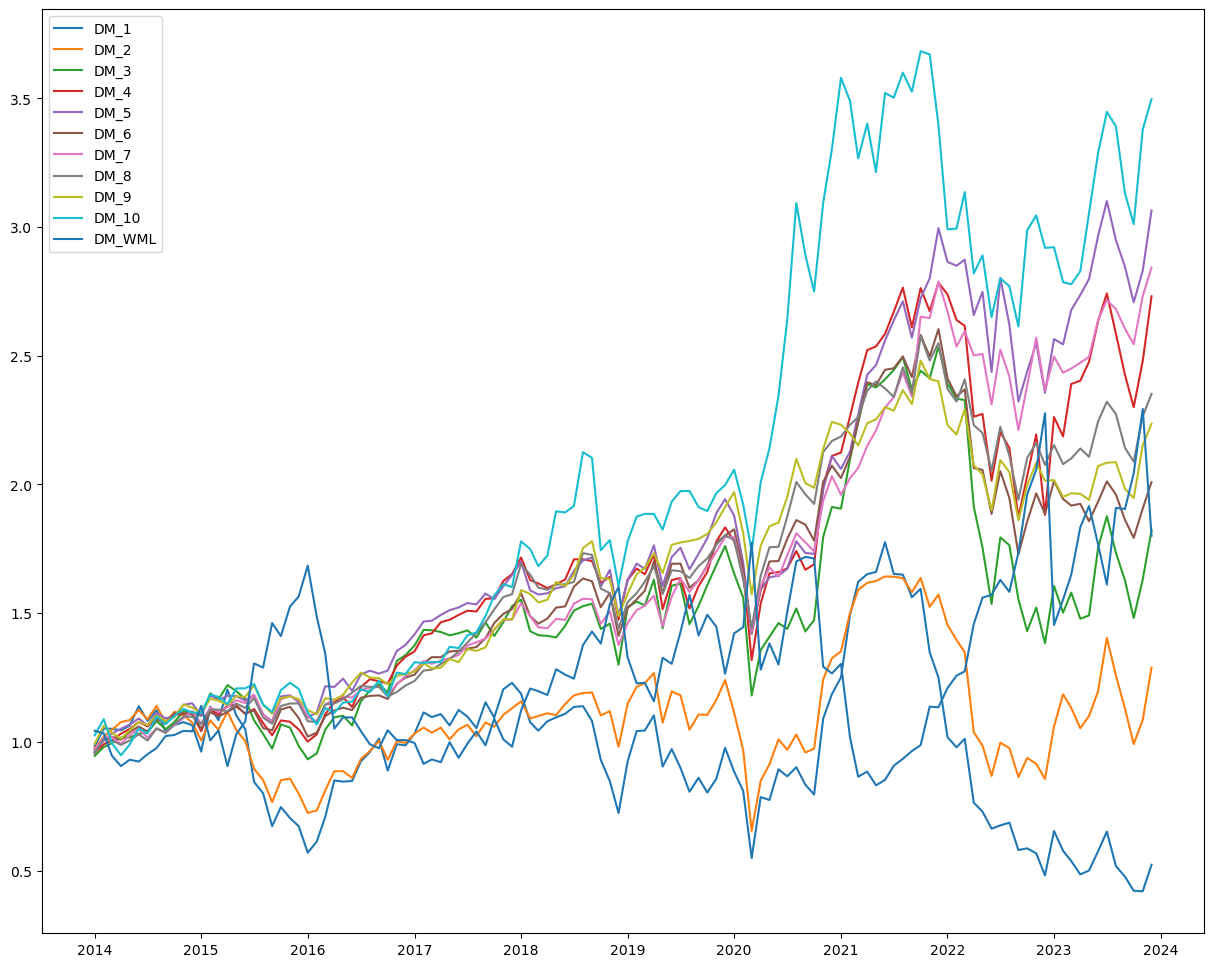

In [25]:
def plot_Q6_DM(CRSP_Stocks_Momentum_returns):
    CRSP_Stocks_Momentum_returns_recent = CRSP_Stocks_Momentum_returns[CRSP_Stocks_Momentum_returns['Year']>2013]
    CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_recent['Year'].astype(str) + '-' + CRSP_Stocks_Momentum_returns_recent['Month'].astype(str).str.zfill(2))
    CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_recent['Date'],format = '%Y%m')
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"WML")
    plt.figure(figsize = (15,12))
    for i in label_list:
        label_col = f"DM_{i}"
        plt.plot(CRSP_Stocks_Momentum_returns_recent['Date'],(1+CRSP_Stocks_Momentum_returns_recent[label_col]-CRSP_Stocks_Momentum_returns_recent['RF']).cumprod(),label = label_col)
    plt.legend()
    plt.show()
    
plot_Q6_DM(CRSP_Stocks_Momentum_returns)

C:\Users\14561\AppData\Local\Temp\ipykernel_26116\923238656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_recent['Year'].astype(str) + '-' + CRSP_Stocks_Momentum_returns_recent['Month'].astype(str).str.zfill(2))
C:\Users\14561\AppData\Local\Temp\ipykernel_26116\923238656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_re

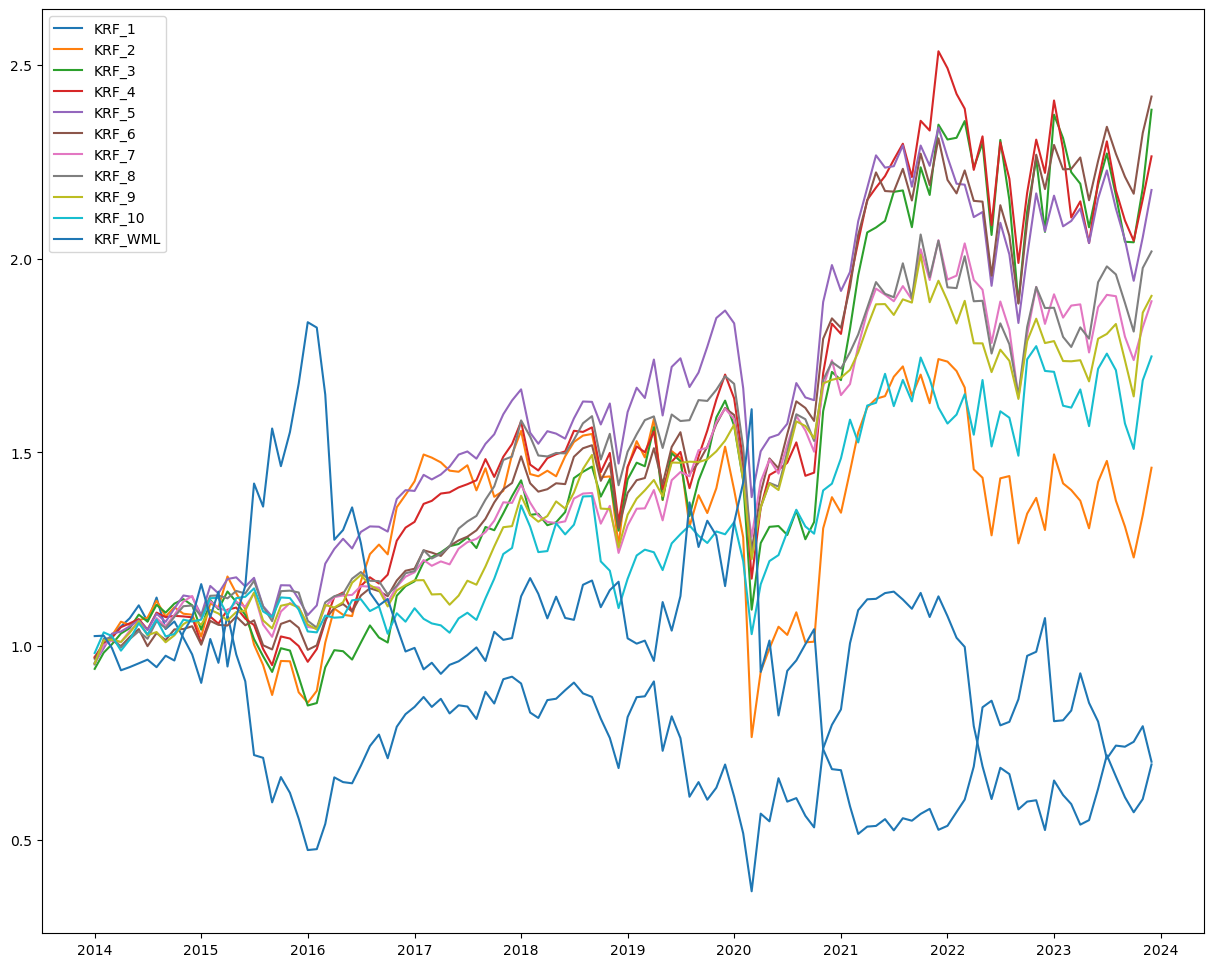

In [26]:
def plot_Q6_KRF(CRSP_Stocks_Momentum_returns):
    CRSP_Stocks_Momentum_returns_recent = CRSP_Stocks_Momentum_returns[CRSP_Stocks_Momentum_returns['Year']>2013]
    CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_recent['Year'].astype(str) + '-' + CRSP_Stocks_Momentum_returns_recent['Month'].astype(str).str.zfill(2))
    CRSP_Stocks_Momentum_returns_recent['Date'] = pd.to_datetime(CRSP_Stocks_Momentum_returns_recent['Date'],format = '%Y%m')
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"WML")
    plt.figure(figsize = (15,12))
    for i in label_list:
        label_col = f"KRF_{i}"
        plt.plot(CRSP_Stocks_Momentum_returns_recent['Date'],(1+CRSP_Stocks_Momentum_returns_recent[label_col]-CRSP_Stocks_Momentum_returns_recent['RF']).cumprod(),label = label_col)
    plt.legend()
    plt.show()
    
plot_Q6_KRF(CRSP_Stocks_Momentum_returns_NYSE)